In [1]:
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D

import torch

/Users/mmosvlad/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [4]:
df = pd.read_csv("/content/drive/Othercomputers/My MacBook Air/Drive/data_new/products_final_embedding.csv")

In [ ]:
df["product_name"] = df["product_name"].apply(lambda x: x.lower())

In [5]:
df

,Unnamed: 0,product_id,product_name,aisle_id,department_id,tokenized_products,embedding
0,0,1,chocolate sandwich cookies,61,19,"[['c'], ['h'], ['o'], ['c'], ['o'], ['l'], ['a...",[-2.93691039e-01 2.81023443e-01 -3.96660894e-...
1,1,3,robust golden unsweetened oolong tea,94,7,"[['r'], ['o'], ['b'], ['u'], ['s'], ['t'], [],...",[-9.79794264e-01 -1.55585036e-01 -1.96261391e-...
2,2,4,smart ones classic favorites mini rigatoni wit...,38,1,"[['s'], ['m'], ['a'], ['r'], ['t'], [], ['o'],...",[-4.61444855e-01 -3.84302586e-01 2.09367997e-...
3,3,8,cut russet potatoes steam n mash,116,1,"[['c'], ['u'], ['t'], [], ['r'], ['u'], ['s'],...",[-3.32874715e-01 1.81423217e-01 -1.95887461e-...
4,4,9,light strawberry blueberry yogurt,120,16,"[['l'], ['i'], ['g'], ['h'], ['t'], [], ['s'],...",[-8.83960351e-02 -3.11358035e-01 -1.11571841e-...
...,...,...,...,...,...,...,...
19974,19974,49679,famous chocolate wafers,61,19,"[['f'], ['a'], ['m'], ['o'], ['u'], ['s'], [],...",[-2.96710789e-01 4.52422380e-01 5.58658428e-...
19975,19975,49680,all natural creamy caesar dressing,89,13,"[['a'], ['l'], ['l'], [], ['n'], ['a'], ['t'],...",[-4.21817571e-01 -1.80106372e-01 -7.22128972e-...
19976,19976,49682,california limeade,98,7,"[['c'], ['a'], ['l'], ['i'], ['f'], ['o'], ['r...",[-7.08907545e-01 -3.42405103e-02 -4.16722357e-...
19977,19977,49683,cucumber kirby,83,4,"[['c'], ['u'], ['c'], ['u'], ['m'], ['b'], ['e...",[-9.41729426e-01 1.27119854e-01 -7.27439344e-...


In [ ]:
# Function to get BERT embedding for a product name
def get_embedding(product_name):
    inputs = tokenizer(product_name, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    # Extract the [CLS] token embedding
    cls_embedding = outputs.last_hidden_state[:, 0, :].numpy().flatten()
    return cls_embedding

In [ ]:
# Generate embeddings for each product name
df['embedding'] = df['product_name'].apply(get_embedding)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
# Choose a few product names to compare similarity
sample_pairs = [
    ("chocolate sandwich cookies", "chocolate fudge layer cake"),  # Expected to be similar
    ("chocolate fudge layer cake", "pizza for one suprema  frozen pizza"),         # Expected to be less similar
]

for name1, name2 in sample_pairs:
    idx1 = df[df['product_name'] == name1].index[0]
    idx2 = df[df['product_name'] == name2].index[0]

    sim = cosine_similarity([df['embedding'].iloc[idx1]], [df['embedding'].iloc[idx2]])
    print(f"Similarity between '{name1}' and '{name2}': {sim}")

Similarity between 'chocolate sandwich cookies' and 'chocolate fudge layer cake': [[0.9620291]]
Similarity between 'chocolate fudge layer cake' and 'pizza for one suprema  frozen pizza': [[0.9367832]]


In [ ]:
# Stack embeddings into a single array for clustering
embeddings = np.stack(df['embedding'].values)

/var/folders/76/dvfp2c2539gf_bf_25xnkmnw0000gn/T/ipykernel_31190/3839571854.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_departments))  # Change 'tab10' to any colormap you like


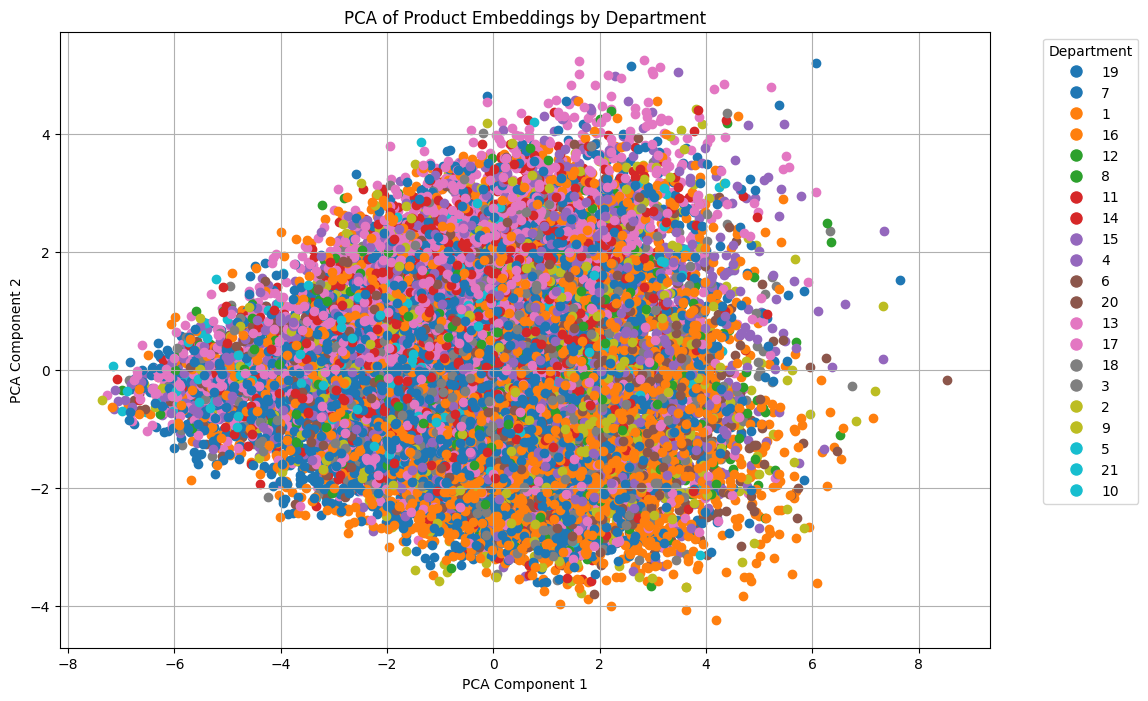

In [ ]:
# Assuming `embeddings` is an array of product embeddings and `df` has the 'department_id' column
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Create a color map for department IDs
unique_departments = df['department_id'].unique()
colors = plt.cm.get_cmap('tab10', len(unique_departments))  # Change 'tab10' to any colormap you like
department_color_map = {dept: colors(i) for i, dept in enumerate(unique_departments)}

# Plot the reduced embeddings with color based on department_id
plt.figure(figsize=(12, 8))  # Increase the size of the plot
for i in range(len(reduced_embeddings)):
    plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1],
                color=department_color_map[df['department_id'].iloc[i]],
                label=df['department_id'].iloc[i] if df['department_id'].iloc[i] not in plt.gca().get_legend_handles_labels()[1] else "")

# Create legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label=str(dept),
                          markerfacecolor=department_color_map[dept], markersize=10)
                   for dept in unique_departments]
plt.legend(handles=legend_elements, title="Department", bbox_to_anchor=(1.05, 1), loc='upper left')

# Optionally annotate product names (comment this out if the plot is too cluttered)
# for i, product_name in enumerate(df['product_name']):
#     plt.annotate(product_name, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))

plt.title('PCA of Product Embeddings by Department')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid()
plt.show()

100%|██████████| 99/99 [28:26<00:00, 17.24s/it]


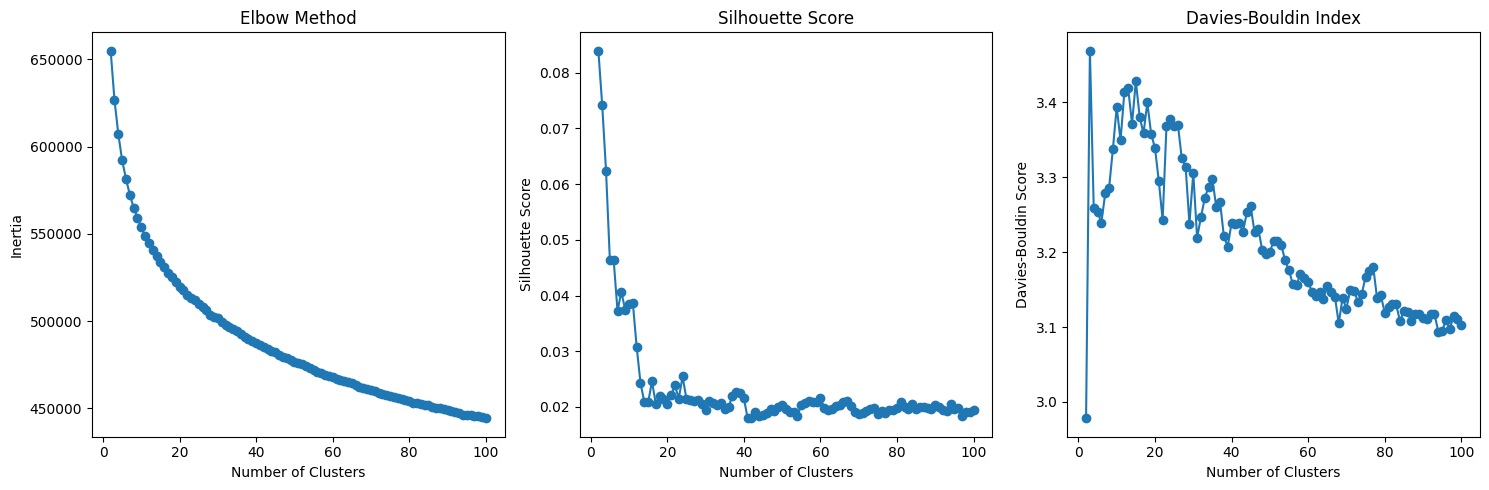

In [ ]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Assuming `embeddings` is your array of product embeddings
range_n_clusters = range(2, 101)  # Change this range as needed

# Initialize lists to hold the scores
inertia = []
silhouette_scores = []
davies_bouldin_scores = []

for n_clusters in tqdm(range_n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings)

    # Inertia for Elbow Method
    inertia.append(kmeans.inertia_)

    # Silhouette Score
    silhouette_avg = silhouette_score(embeddings, cluster_labels)
    silhouette_scores.append(silhouette_avg)

    # Davies-Bouldin Score
    db_score = davies_bouldin_score(embeddings, cluster_labels)
    davies_bouldin_scores.append(db_score)

# Plotting the results
plt.figure(figsize=(15, 5))

# Elbow Method
plt.subplot(1, 3, 1)
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

# Silhouette Score
plt.subplot(1, 3, 2)
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

# Davies-Bouldin Index (lower is better)
plt.subplot(1, 3, 3)
plt.plot(range_n_clusters, davies_bouldin_scores, marker='o')
plt.title('Davies-Bouldin Index')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Score')

plt.tight_layout()
plt.show()

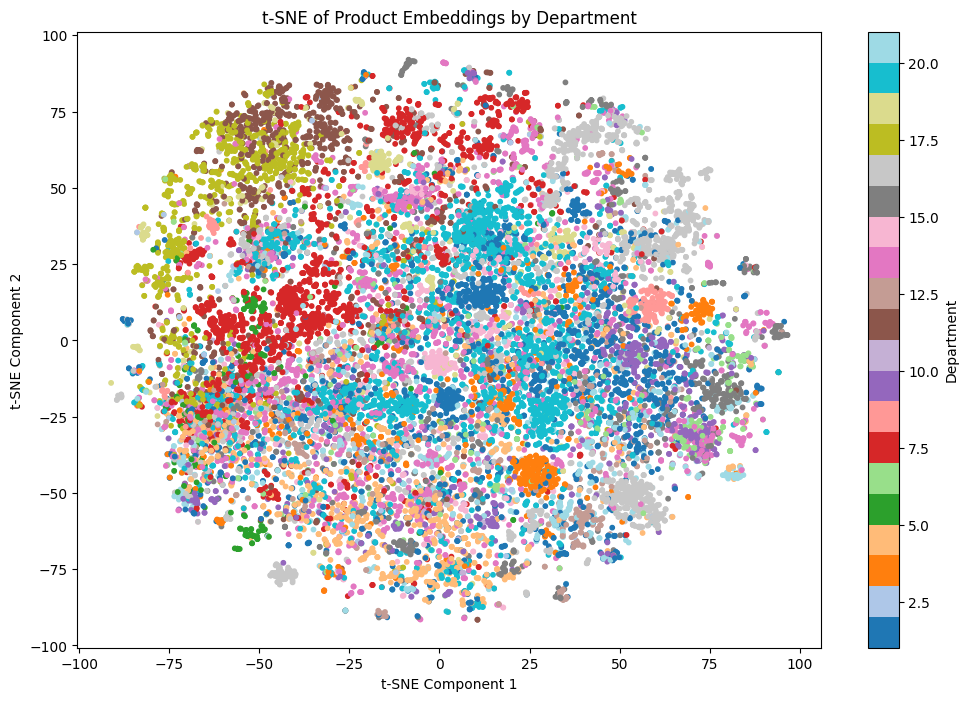

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Виконуємо t-SNE для зменшення вимірності до 2 компонентів
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings_tsne = tsne.fit_transform(embeddings)

# Візуалізуємо результат
plt.figure(figsize=(12, 8))
scatter = plt.scatter(reduced_embeddings_tsne[:, 0], reduced_embeddings_tsne[:, 1], c=df['department_id'], cmap='tab20', s=10)
plt.colorbar(scatter, label='Department')
plt.title('t-SNE of Product Embeddings by Department')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

/Users/mmosvlad/anaconda3/envs/dataspell/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


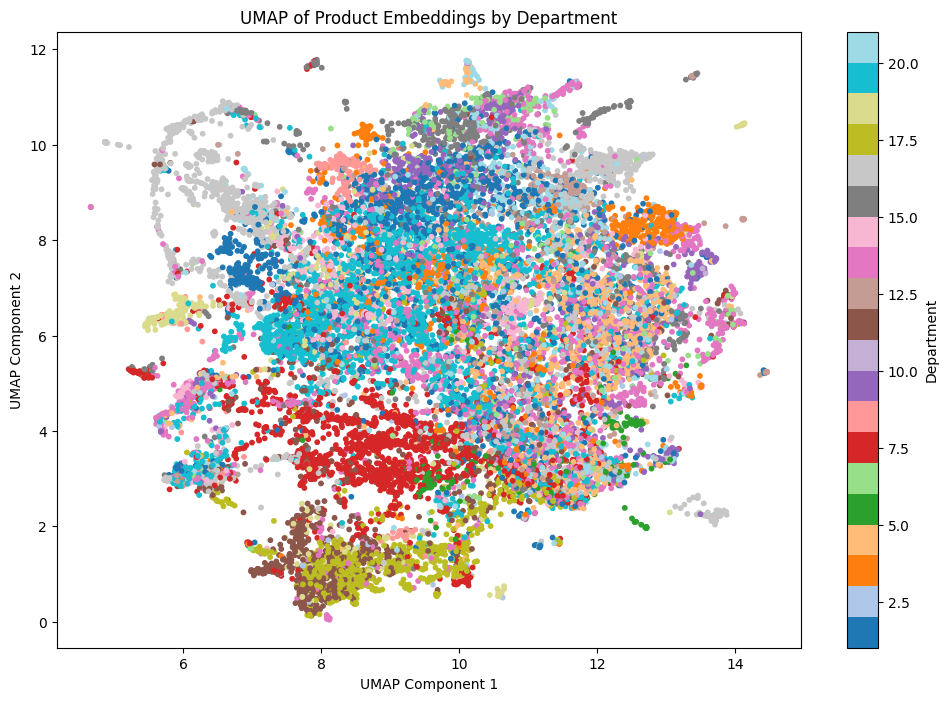

In [ ]:
import umap
import matplotlib.pyplot as plt

# Виконуємо UMAP для зменшення вимірності до 2 компонентів
umap_reducer = umap.UMAP(n_components=2, random_state=42)
reduced_embeddings_umap = umap_reducer.fit_transform(embeddings)

# Візуалізуємо результат
plt.figure(figsize=(12, 8))
scatter = plt.scatter(reduced_embeddings_umap[:, 0], reduced_embeddings_umap[:, 1], c=df['department_id'], cmap='tab20', s=10)
plt.colorbar(scatter, label='Department')
plt.title('UMAP of Product Embeddings by Department')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

In [ ]:
df.to_csv("data_new/testing_products_embedding/products_final_embedding.csv")